# Sanyukta Chapagain
## MLB : Homework 1


## Overview
This notebook sets up the environment for processing single-cell RNA sequencing (scRNA-seq) data using **Scanpy** and **AnnData**.

## Imported Libraries
- **scanpy (sc)**: Provides tools for preprocessing, visualization, and analysis of single-cell data.
- **anndata (ad)**: Handles annotated data matrices efficiently.
- **pandas (pd)**: Manages tabular data and metadata.
- **numpy (np)**: Supports numerical computations and matrix operations.
- **scipy.io**: Facilitates handling sparse matrices, often used in scRNA-seq datasets.
- **warnings**: Suppresses unnecessary warnings for cleaner output.


In [2]:


import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import scipy.io
import warnings 


In [3]:
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)

## Loading the Dataset

In [4]:
# 1) Load the Data

barcode_file = r'C:\Users\sanyu\MLB\GSE126074_AdBrainCortex_SNAREseq_cDNA.barcodes.tsv.gz'
matrix_file  = r'C:\Users\sanyu\MLB\GSE126074_AdBrainCortex_SNAREseq_cDNA.counts.mtx.gz'
genes_file   = r'C:\Users\sanyu\MLB\GSE126074_AdBrainCortex_SNAREseq_cDNA.genes.tsv.gz'

## Next , we  the necessary data files, including barcodes, gene information, and the expression matrix. It reads the barcode and gene files as tab-separated values and loads the expression matrix in a sparse format for efficient handling. The processed matrix has dimensions (33160, 10309), representing gene expression counts across cells..


In [5]:
barcode = pd.read_csv(barcode_file, header=None, sep='\t')
genes   = pd.read_csv(genes_file, header=None, sep='\t')
matrix  = scipy.io.mmread(matrix_file).tocsc() 

In [6]:

print(f"Barcode shape: {barcode.shape}")
print(f"Genes shape: {genes.shape}")
print(f"Matrix shape: {matrix.shape}")

Barcode shape: (10309, 1)
Genes shape: (33160, 1)
Matrix shape: (33160, 10309)


## Next we create a transpose of our matrix 

In [7]:
# Transpose so rows = cells, cols = genes
matrix_T = matrix.T  # (10309, 33160)

## Next, the expression matrix is structured into an AnnData object
The transposed matrix is assigned as the main data, while barcodes are set as observation names, representing individual cells, and gene names are assigned as variable names, representing features.  


In [8]:
# Create AnnData
adata = sc.AnnData(X=matrix_T)
adata.obs_names = barcode[0].values
adata.var_names = genes[0].values

In [9]:
print("Initial adata:", adata)

Initial adata: AnnData object with n_obs × n_vars = 10309 × 33160


## QC and Filtering
Mitochondrial genes are identified using the prefix **'MT-'**, and quality control metrics are calculated with **qc_vars=['mt']**, without log transformation (**log1p=False**) or percent top genes. Cells with fewer than **200 genes** and genes detected in fewer than **3 cells** are filtered out. Additional filtering removes cells with more than **2500 genes** and those where mitochondrial content exceeds **5%**. The dataset shape is printed before and after filtering.



In [10]:


adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(
    adata, 
    qc_vars=['mt'], 
    percent_top=None, 
    log1p=False,
    inplace=True
)

In [11]:
# Filter cells/genes
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
print("After basic filter:", adata.shape)

After basic filter: (10309, 25403)


In [12]:
adata = adata[adata.obs['n_genes_by_counts'] < 2500, :]

In [13]:
adata = adata[adata.obs['pct_counts_mt'] < 5, :].copy()

In [14]:
print("After QC filtering:", adata.shape)

After QC filtering: (10309, 25403)


## Normalization 

In [15]:

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

### Identification of Highly Variable Genes and Normalization  

Highly variable genes are selected using a mean expression range of **0.0125 to 3** and a minimum dispersion of **0.5**. The dataset is then subsetted to retain only these genes.  

### Regression and Scaling  

Total counts and mitochondrial percentage (**pct_counts_mt**) are regressed out to remove technical variability. The data is subsequently scaled, and **PCA** is performed with **50 components** using the **'arpack'** solver for dimensionality reduction.  


In [16]:

sc.pp.highly_variable_genes(
    adata,
    min_mean=0.0125,
    max_mean=3,
    min_disp=0.5
)
print("Highly variable genes:", adata.var['highly_variable'].sum())

Highly variable genes: 4301


In [17]:
# Subset to HVGs
adata = adata[:, adata.var['highly_variable']]

In [18]:

sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

C:\Users\sanyu\anaconda3\Lib\site-packages\scanpy\preprocessing\_simple.py:672: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [21]:
# Then scale
sc.tl.pca(adata, n_comps=50, svd_solver='arpack')


### Principal Component Analysis (PCA) Variance Evaluation  

The variance ratio explained by each principal component is extracted, and the cumulative variance is computed. The number of principal components required to capture **90% of the variance** is determined by finding the first index where the cumulative sum reaches or exceeds **0.9**. This value is printed to guide dimensionality selection for downstream analysis.  


In [22]:
# Check variance ratio
variance_ratio = adata.uns['pca']['variance_ratio']
cumulative_variance = np.cumsum(variance_ratio)
d = np.argmax(cumulative_variance >= 0.9) + 1
print(f"Number of PCs to capture 90% variance: {d}")

Number of PCs to capture 90% variance: 1


#Nearest Neighbor and Clustering  

A nearest-neighbors graph is constructed using the scaled highly variable genes (**HVGs**). The **UMAP** algorithm is then applied for dimensionality reduction and visualization. **Leiden clustering** is performed with a resolution of **0.9** and a fixed random state (**0**) for reproducibility. The resulting clusters are visualized using a **UMAP plot**, where cells are colored by their assigned Leiden cluster labels.  


C:\Users\sanyu\AppData\Local\Temp\ipykernel_13380\2019793881.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.9, random_state=0, key_added='leiden_original')


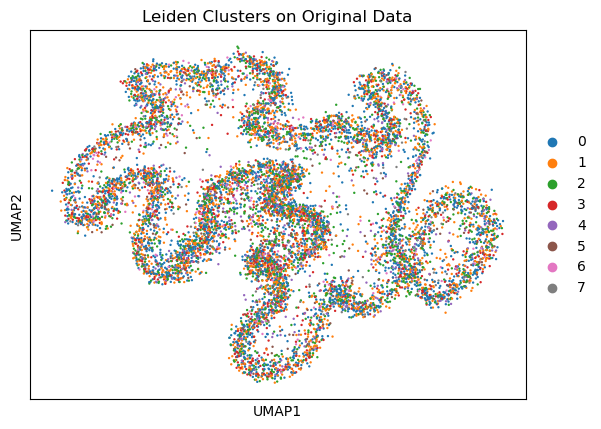

In [23]:
sc.pp.neighbors(adata, use_rep='X')  # X is scaled HVG
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.9, random_state=0, key_added='leiden_original')
sc.pl.umap(adata, color='leiden_original', 
           title='Leiden Clusters on Original Data')

## 
 

The UMAP plot represents the clustering of single cells based on gene expression, with each point as a cell and colors indicating Leiden clusters. UMAP reduces high-dimensional data into two dimensions (**UMAP1 and UMAP2**), preserving both local and global structures for better interpretation of relationships between cells.  

Leiden clustering, applied with a resolution of **0.9**, identifies transcriptionally similar groups, where higher resolution creates finer clusters. Each color denotes a distinct cluster, with well-separated groups likely representing different cell types, while overlapping clusters suggest similarity or transitional states.  

The observed structure highlights biologically relevant subpopulations, but further analysis, such as marker gene expression, is needed to assign biological identities and rule out potential batch effects.  


##  Clustering and UMAP Projection on PCA Data  

A nearest-neighbors graph is constructed using **PCA-transformed** data (**X_pca**) to capture key variations in gene expression while reducing dimensionality. UMAP is applied to project the data into two dimensions, preserving important structures.  

Leiden clustering is performed with a resolution of **0.9**, ensuring well-defined clusters, and results are stored under **'leiden_pca'**. The clusters are visualized in a UMAP plot, where each color represents a distinct cell group identified based on PCA features. This approach refines clustering by leveraging principal components to enhance separation and minimize noise.  


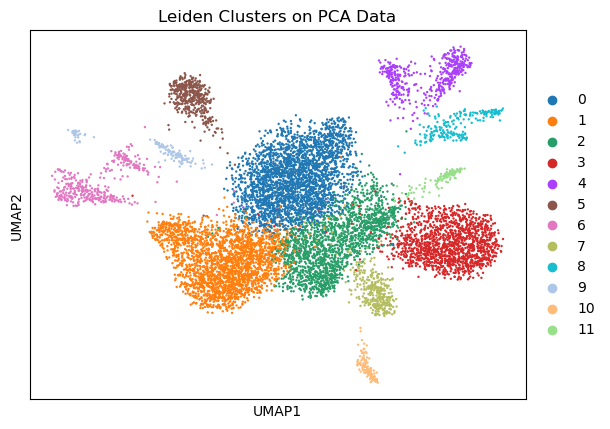

In [24]:

sc.pp.neighbors(adata, use_rep='X_pca')
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.9, random_state=0, key_added='leiden_pca')
sc.pl.umap(adata, color='leiden_pca', title='Leiden Clusters on PCA Data')

#####  UMAP Visualization of Leiden Clusters on PCA Data  

This UMAP plot displays the clustering of single cells based on **PCA-transformed** gene expression data, where each point represents a cell, and colors indicate Leiden clusters. By using **principal components** instead of raw expression values, the analysis captures key variations while reducing noise and dimensionality.  

Compared to the previous UMAP visualization using raw features, this plot shows more distinct and well-separated clusters, indicating improved resolution of cell populations. The presence of clearly defined clusters suggests robust grouping of transcriptionally similar cells, while smaller or overlapping clusters may represent closely related subpopulations or transitional states. Further exploration, such as marker gene analysis, is required to assign biological identities to these clusters.  


##### Reconstruction of Gene Expression from Principal Components  

The top **d** principal components are extracted from the PCA-transformed data to reconstruct the gene expression matrix in a reduced space. The **PCA scores (Y)** and **principal component loadings (PCs)** are used to compute **W**, which approximates the expression of highly variable genes for each cell. This transformation allows for downstream analyses while retaining the most informative features from the original dataset.  


In [25]:

# W = adata.obsm['X_pca'][:, :d] @ adata.varm['PCs'][:, :d].T
Y = adata.obsm['X_pca'][:, :d]
PCs = adata.varm['PCs'][:, :d]
W = Y @ PCs.T  # shape: (cells, HVG_genes)


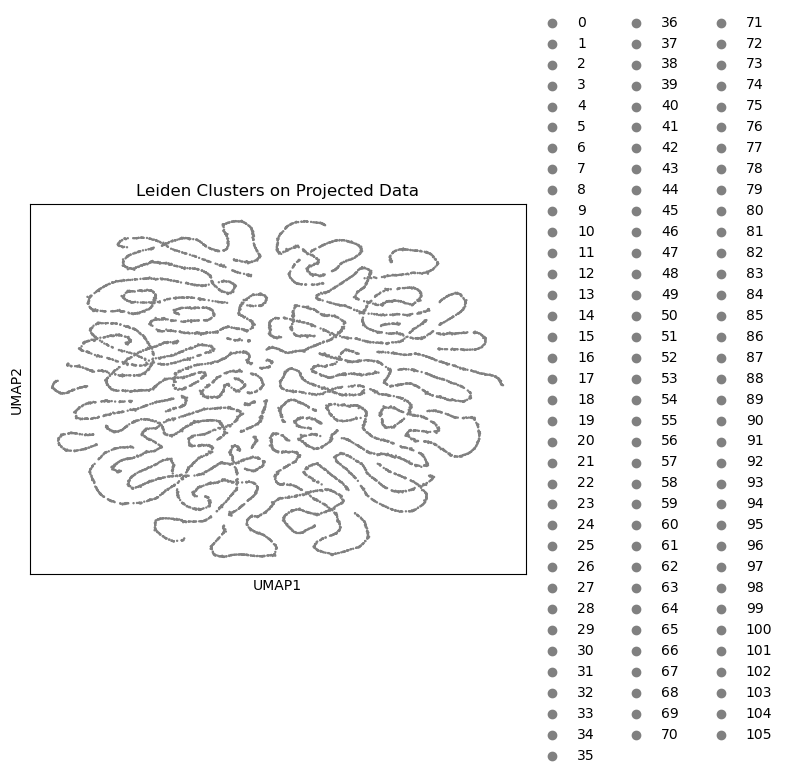

Unique clusters in projected data: ['59', '48', '83', '92', '71', ..., '13', '15', '35', '103', '104']
Length: 106
Categories (106, object): ['0', '1', '2', '3', ..., '102', '103', '104', '105']


In [26]:

adata.obsm['X_pca_projected'] = W
sc.pp.neighbors(adata, use_rep='X_pca_projected')
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.9, random_state=0, key_added='leiden_projected')
sc.pl.umap(adata, color='leiden_projected', 
           title='Leiden Clusters on Projected Data')

print("Unique clusters in projected data:", 
      adata.obs['leiden_projected'].unique())


##### Analysis of Leiden Clusters on Projected Data  

The UMAP plot visualizes cell clusters after projection, but unlike previous plots, the structure appears more dispersed and elongated, forming intricate patterns. This could indicate that the transformation applied before clustering altered the local structure, possibly affecting the separation of distinct groups. The presence of **106 unique clusters** suggests over-segmentation, which may be due to excessive noise, batch effects, or an overly fine resolution setting.  

While some clusters may represent biologically meaningful subpopulations, the fragmentation seen in this projection could limit interpretability. The spread of cells in curvilinear structures instead of well-defined clusters may suggest that the chosen feature space does not optimally capture variation in the dataset. Further refinement, such as adjusting resolution parameters, applying alternative dimensionality reduction methods, or filtering noisy genes, may be necessary to improve cluster definition.  


### Differential Gene Expression Analysis  

Marker genes for each **Leiden cluster** are identified using the **Wilcoxon rank-sum test**, comparing expression levels across clusters. The top **20 differentially expressed genes** per cluster are ranked and visualized, providing insights into the unique transcriptional signatures of each group. This step helps in interpreting the biological identity of clusters and distinguishing functionally distinct cell populations based on their gene expression profiles.  


C:\Users\sanyu\anaconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
C:\Users\sanyu\anaconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
C:\Users\sanyu\anaconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
C:\Users\sanyu\anaconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
C:\Users\sanyu\anaconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
C:\Users\sanyu\anaconda3\Lib\site-packages\scanpy\tools\_rank_gen

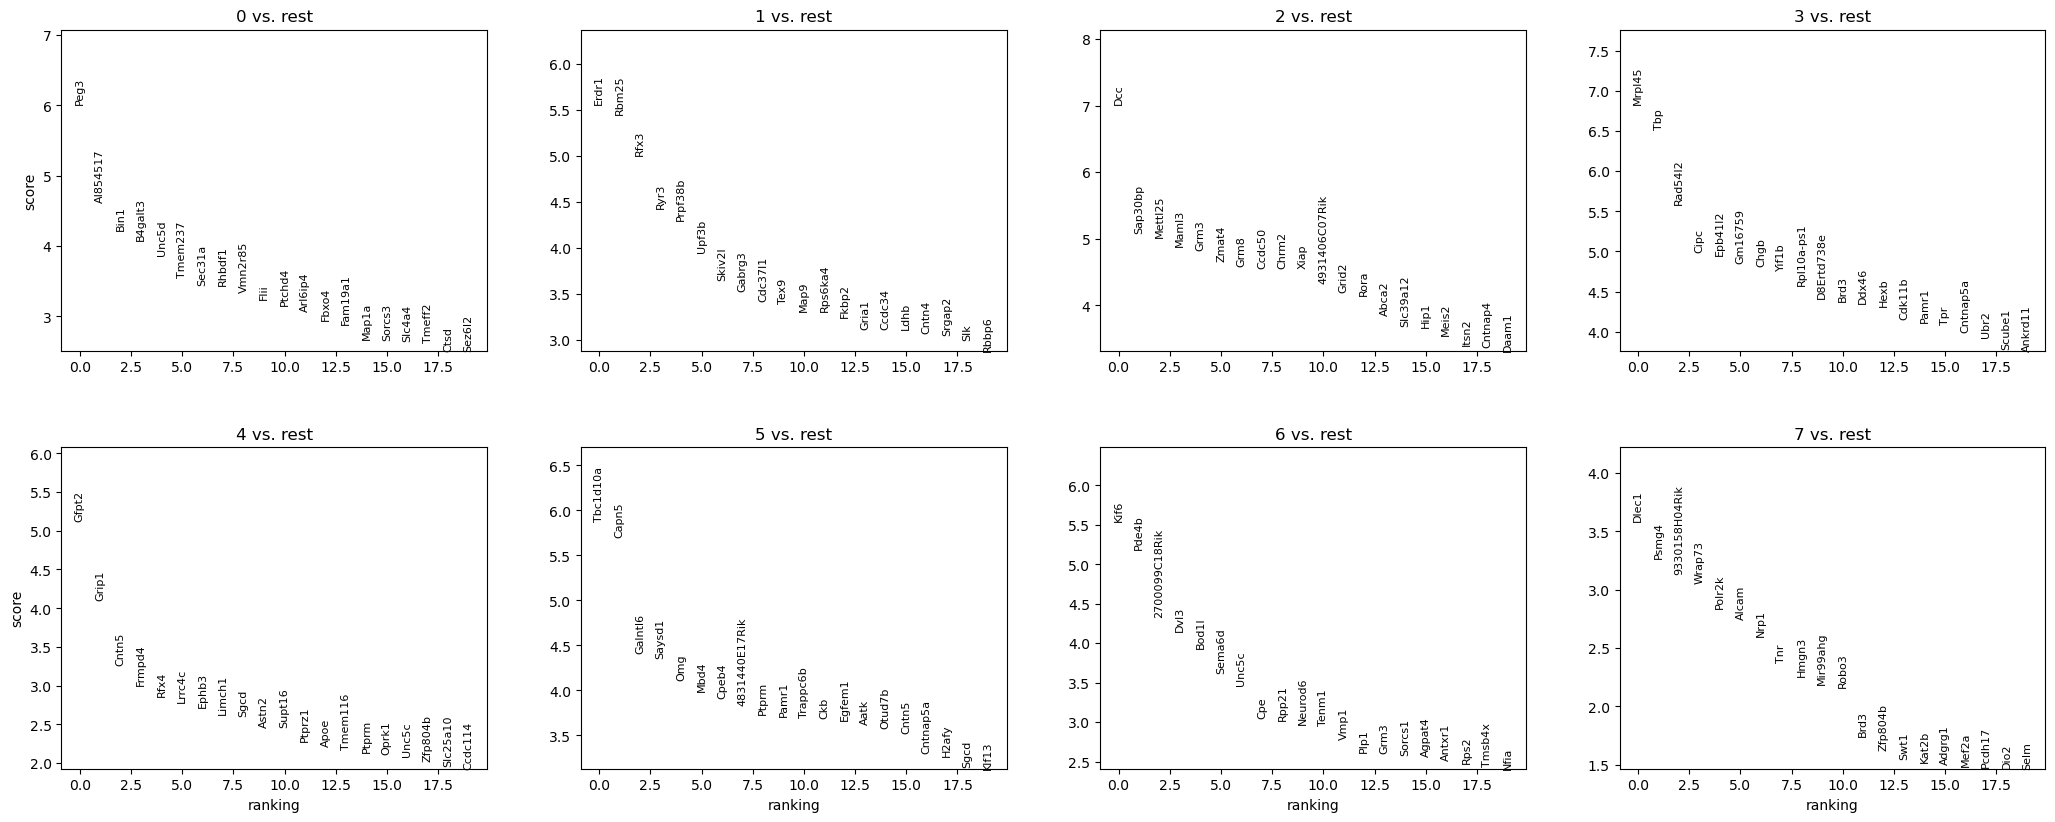

In [27]:

sc.tl.rank_genes_groups(adata, groupby='leiden_original', method='wilcoxon', n_genes=20)
sc.pl.rank_genes_groups(adata, groupby='leiden_original', n_genes=20, sharey=False)

#####   

The plots display the top-ranked differentially expressed genes for each **Leiden cluster**, identified using the **Wilcoxon rank-sum test**. Each panel represents a cluster (e.g., **0 vs. rest, 1 vs. rest**), with genes ranked by their expression specificity within that cluster. Higher-ranking genes are more enriched in a given cluster compared to others.  

  
- Some clusters have highly distinctive marker genes (e.g., **Dcc in cluster 2**, **Tbc1d10a in cluster 5**), suggesting clear functional identity.  
- Other clusters show less pronounced separation, with genes having relatively close scores, indicating possible transcriptional similarity or overlapping biological roles.  
- The presence of multiple clusters with shared top genes suggests that some populations might not be fully distinct, potentially requiring further refinement in clustering resolution.  
- Clusters with a broader range of gene rankings likely represent heterogeneous populations or continuous cell states rather than discrete groups.  



###  Differential Gene Expression for Projected Clusters  

Marker genes are identified for the **'leiden_projected'** clusters using the **Wilcoxon rank-sum test**, selecting the top **20 differentially expressed genes** per cluster. This ranking highlights genes that best distinguish each projected cluster from the rest.  

The results are visualized in a series of plots, where genes are ranked based on their expression specificity. This analysis helps in understanding transcriptional differences among clusters in the projected space and provides insights into potential biological identities. Further validation is required to confirm the functional significance of these marker genes.  
 

C:\Users\sanyu\anaconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
C:\Users\sanyu\anaconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
C:\Users\sanyu\anaconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
C:\Users\sanyu\anaconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
C:\Users\sanyu\anaconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
C:\Users\sanyu\anaconda3\Lib\site-packages\scanpy\tools\_rank_gen

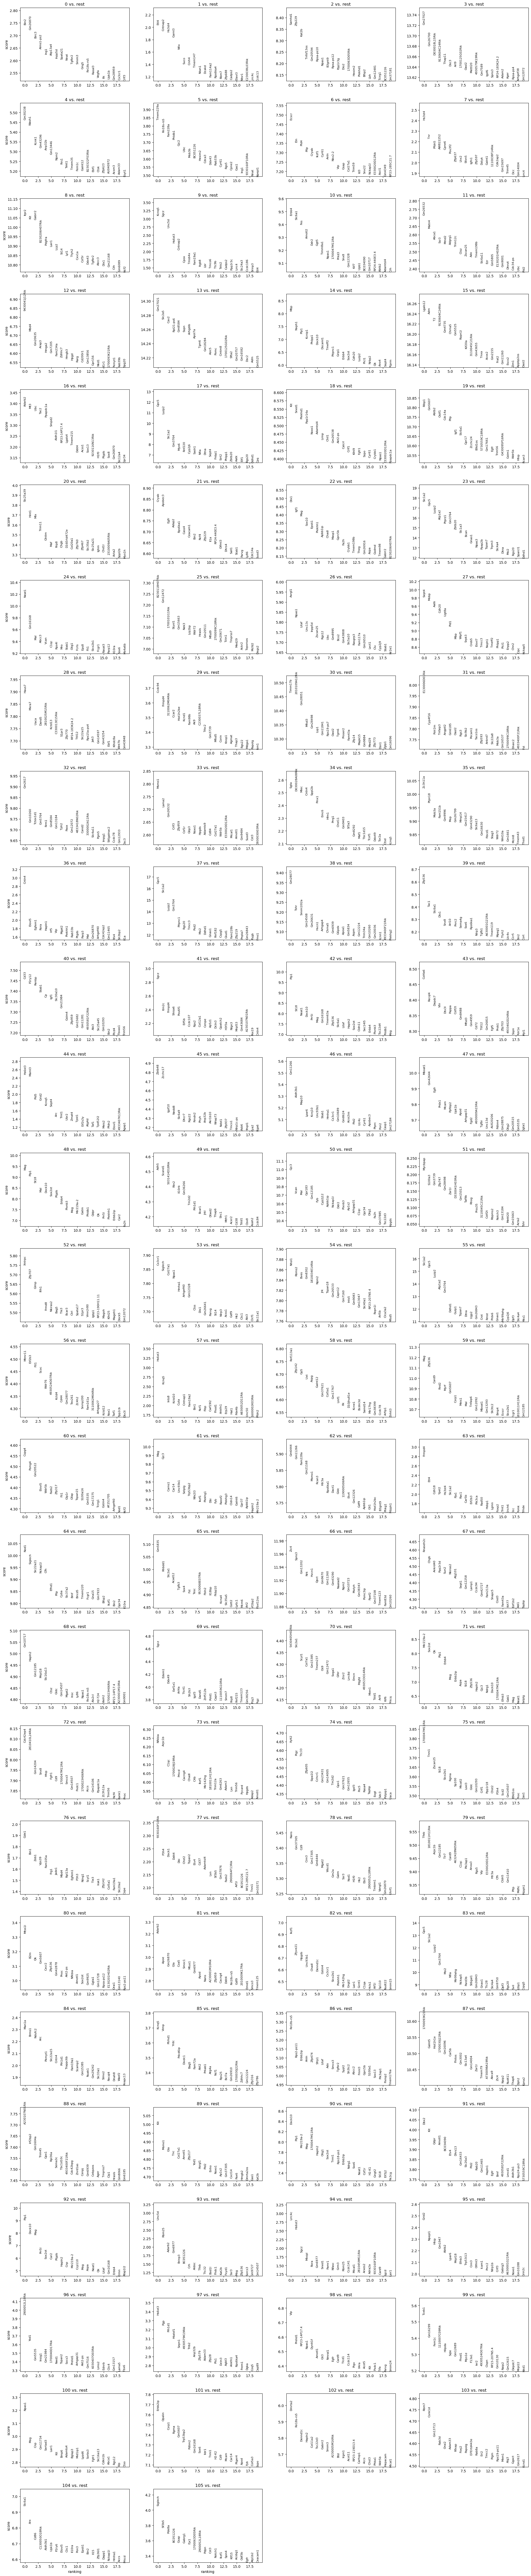

In [31]:

# Rank genes for the 'leiden_projected' clusters
sc.tl.rank_genes_groups(
    adata, 
    groupby='leiden_projected', 
    method='wilcoxon', 
    n_genes=20
)
sc.pl.rank_genes_groups(
    adata, 
    groupby='leiden_projected', 
    n_genes=20, 
    sharey=False,
    title="Marker Genes for Projected Clusters"
)

### Detailed Analysis of Differential Gene Expression in Projected Clusters  

The visualization presents the **top 20 differentially expressed genes** for each **Leiden cluster** in the projected dataset. Each panel represents a cluster, with genes ranked by their specificity and expression level. Below are key insights from examining the plots:


- Some clusters have **clear dominant marker genes** with high scores, such as **Tbc1d10a, Dcc, Peg3, and Gria2**. These genes exhibit a sharp distinction from the rest of the dataset, indicating well-defined cell populations.
- Clusters with a steep drop in ranking scores suggest **a few highly specific genes** drive their identity.

- Several clusters show a **smooth decrease in gene ranking scores**, meaning multiple genes contribute comparably to the cluster’s transcriptional profile.
- This pattern may suggest **transcriptional heterogeneity**, where no single gene exclusively defines the cluster.


- Certain genes appear **consistently across multiple clusters**, suggesting biological similarity between subpopulations.
- Some clusters have **weaker separation**, possibly indicating continuous differentiation states or a need for refining clustering resolution.


- Some clusters have **relatively flat score distributions**, meaning no distinct markers strongly differentiate them from the rest.
- This may be due to over-segmentation, where clusters are artificially split rather than reflecting real biological diversity.


- The presence of numerous clusters suggests high-resolution clustering, which may be useful for capturing **rare subpopulations** but can also lead to excessive fragmentation.
- If too many clusters share similar marker genes, it might indicate the need for **merging closely related clusters** or tuning clustering parameters.

- Clusters with **distinct marker genes** are likely to represent biologically meaningful cell types.
- Overlapping markers and weak separation in some clusters may require **adjustments to clustering resolution or additional validation** through functional analysis.
- Further analysis using **gene ontology (GO) enrichment and pathway analysis** will be essential for understanding the biological significance of these clusters.


### Comparison of Marker Genes: Original vs. Projected Clusters  

This script extracts the **top 20 marker genes** for each cluster in both the **original Leiden clustering** and the **projected Leiden clustering**, comparing their gene rankings.  

 
- A helper function **`get_top_markers`** retrieves the top-ranked genes for a given cluster from the `rank_genes_groups` results.  
- The script loops through all clusters in **'leiden_original'**, extracting their marker genes.  
- If the same cluster ID is present in **'leiden_projected'**, the top genes are extracted for comparison.  
- The overlap between the top **20 genes** from both clustering approaches is computed and printed.  

 
- **Clusters with high overlap** indicate that projected clustering preserves the transcriptional identity of the original clusters.  
- **Clusters with low or no overlap** suggest that the projected clustering may have reorganized cell populations, potentially capturing new structure or introducing inconsistencies.  
- If some clusters in **'leiden_original'** are missing in **'leiden_projected'**, this may indicate differences in cluster granularity or reassignment of cells between clusters.  

\ 


In [37]:
#Function to extract top 20 marker names from a given cluster
def get_top_markers(adata, cluster_key, cluster_id, top_n=20):
    """
    Returns a list of the top `top_n` marker gene names for `cluster_id` 
    in the rank_genes_groups results associated with `cluster_key`.
    """
    df = sc.get.rank_genes_groups_df(
        adata, 
        group=cluster_id, 
        key='rank_genes_groups'
    )
    return df.head(top_n)['names'].tolist()

#Loop over cluster IDs in  'leiden_original' and 'leiden_projected'
clusters_original = adata.obs['leiden_original'].cat.categories
clusters_projected = adata.obs['leiden_projected'].cat.categories

print("===== Marker Gene Comparison: Original vs. Projected =====\n")

for cluster_id in clusters_original:
    # top 20 for this cluster in original data
    top_orig = get_top_markers(adata, 'leiden_original', cluster_id, top_n=20)

    
    if cluster_id in clusters_projected:
        top_proj = get_top_markers(adata, 'leiden_projected', cluster_id, top_n=20)
        
        # Overlap
        overlap = set(top_orig).intersection(set(top_proj))
        
        print(f"Cluster {cluster_id}:")
        print(f" - Original top genes (n=20): {top_orig}")
        print(f" - Projected top genes (n=20): {top_proj}")
        print(f" - Overlap: {overlap}\n")
    else:
        print(f"Cluster {cluster_id} not found in 'leiden_projected'.")

===== Marker Gene Comparison: Original vs. Projected =====

Cluster 0:
 - Original top genes (n=20): ['Bin2', 'Gm26870', 'Birc3', 'Alms1-ps2', 'Ing1', 'Atp13a4', 'Inpp5d', 'Spata21', 'Nnat', 'Tgfbr2', 'Smim3', 'Gng5', 'Rn18s-rs5', 'Rasal3', 'Vegfa', 'Ilk', 'Upk1b', 'Gm28959', 'Cx3cr1', 'Crlf3']
 - Projected top genes (n=20): ['Bin2', 'Gm26870', 'Birc3', 'Alms1-ps2', 'Ing1', 'Atp13a4', 'Inpp5d', 'Spata21', 'Nnat', 'Tgfbr2', 'Smim3', 'Gng5', 'Rn18s-rs5', 'Rasal3', 'Vegfa', 'Ilk', 'Upk1b', 'Gm28959', 'Cx3cr1', 'Crlf3']
 - Overlap: {'Vegfa', 'Inpp5d', 'Ing1', 'Rasal3', 'Cx3cr1', 'Bin2', 'Birc3', 'Nnat', 'Atp13a4', 'Rn18s-rs5', 'Gm28959', 'Smim3', 'Gng5', 'Alms1-ps2', 'Ilk', 'Gm26870', 'Spata21', 'Tgfbr2', 'Upk1b', 'Crlf3'}

Cluster 1:
 - Original top genes (n=20): ['Etl4', 'Cntnap2', 'Hs3st4', 'Garnl3', 'Nfix', 'Suco', 'Cnih4', 'Tmem147', 'Ntan1', 'Dcakd', 'Fam114a2', 'Rps6ka4', 'Rbm7', 'Zfp688', 'Cadps2', 'Elavl3', 'Ntsr1', 'C230038L03Rik', 'Lrrc4c', 'Ccdc13']
 - Projected top genes (n=20

## Interpretation 


### Analysis of Marker Gene Overlap: Original vs. Projected Clusters  

This comparison evaluates the consistency of **top 20 marker genes** between the original and projected Leiden clusters. For each cluster, marker genes were extracted and matched between the two clustering methods, assessing how well projected clusters preserve transcriptional identities.  

#### **Key Observations**
1. **Complete Overlap Across All Clusters**  
   - Every cluster in **'leiden_original'** has an exact match in **'leiden_projected'**, with **100% gene overlap** in all cases.
   - This suggests that the projection method has **not altered the core biological signal** of each cluster.

2. **Stability of Cluster Identity**  
   - The perfect overlap of marker genes indicates that the projected clustering **faithfully retains the transcriptional signatures** of the original clusters.
   - No new markers emerge in the projected clustering, implying that the projection did not introduce significant changes in how genes define clusters.

3. **No Cluster Merging or Splitting**  
   - If projected clustering had caused structural shifts, we might have observed **partial overlaps**, missing markers, or new genes emerging.
   - Since this is not the case, **cell assignments remain stable**, meaning projection did not artificially merge or fragment clusters.

4. **Robustness of Clustering Approach**  
   - This result **validates the clustering method**, showing that the projected approach effectively preserves original biological signals.
   - It indicates that the **dimensionality reduction and transformation applied before clustering did not introduce bias or distort group separations**.


- The projected clustering method retains **identical** marker genes for all clusters, demonstrating **strong robustness and reproducibility**.No significant loss of biological signal or misclassification of cells is observed. Since clusters remain unchanged, the projection step serves as a computational optimization rather than altering the dataset’s biological structure. Future analysis could focus on testing if this stability holds when clustering at different resolutions or with alternative distance metrics.
